The tuning process in this notebook is similar to the one executed in the daily notebook, so fewer explanations will be written throughout this notebook. For a more detailed explanation of the thought-processes behind tuning, see the daily notebook.

## Import Libraries and Load Data

In [1]:
from prophet import Prophet
import modules.preprocessing as prep
import modules.modeling as mdl
import modules.evaluation as ev
import os

In [2]:
# Load dataset
df = prep.load_dataset('../data/SN_m_tot_V2.0.csv')
df

,year,month,predicted_sunspots
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7
...,...,...,...
3275,2021,12,67.5
3276,2022,1,54.0
3277,2022,2,59.7
3278,2022,3,78.5


In [3]:
# Create processed dataframe for use by Prophet and extract periodicity for forecasting
periodic_df, periodicity = prep.create_periodic_dataframe(df)
periodic_df

,ds,y
0,1749-01-01,96.7
1,1749-02-01,104.3
2,1749-03-01,116.7
3,1749-04-01,92.8
4,1749-05-01,141.7
...,...,...
3275,2021-12-01,67.5
3276,2022-01-01,54.0
3277,2022-02-01,59.7
3278,2022-03-01,78.5


In [4]:
# Define number of future periods to forecast and base paths for saving models and forecasts
future_periods = [1, 6, 9]
models_base_path = os.path.join('..', 'models', 'monthly')
forecasts_base_path = os.path.join('..', 'forecasts', 'monthly')

## Base Model Statistics

In [5]:
# Fit base model
model_name = 'base_monthly'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {}
seasonality_params = {}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

In [6]:
# Calculate metrics of base model
model = ev.load_pickle(model_path)
forecast = ev.load_pickle(forecast_path)
ev.calculate_errors(periodic_df, forecast[0])

Pickled object at ../models/monthly/base_monthly.pickle loaded successfully.
Pickled object at ../forecasts/monthly/base_monthly.pickle loaded successfully.


,mae,mape,r2
Model Errors,53.337921,4.834923,0.064501


## Model Tuning

Naming scheme:\
{sampling frequency}\_\_s-{seaonality_params}\_\_-g-{growth_type}\_\_-cp-{changepoint_prior}\_\_cn-{num_changepoints}.pickle\
Multiple params of same type separated by single _\
s = custom seasonality in form KyPf where K is the number of years and P is the Fourier Order\
g = growth type, default linear\
cp = changepoint prior frequency as a percent, default 5%\
cn = number of changepoints, default 25

## Tuning Seasonality

### 11 Years Custom Seasonality, Differing Fourier Orders

Note that Prophet requires seasonalities to be specified in days, regardless of the frequency of the fitted dataset. Thus, the period is still 4017.75.

In [7]:
# Test on Fourier Order 5, 10, 20, 40, 80, 160, 200, and 240
fourier_orders = [5, 10, 20, 40, 80, 120, 160, 200, 240]
model_names = [f'monthly__s-11y{x}f__g-linear__cp-5__cn-25' for x in fourier_orders]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]

base_params = {'df': periodic_df, 'func': Prophet}
func_params = {'yearly_seasonality': False}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     seasonality_params = {f'11 Year, Fourier {fourier_orders[i]}':
#                               {'period': 4017.75, 'fourier_order': fourier_orders[i]}}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

The size of the dataset is much lower which makes training the model take less time. The model improves until Fourier order 160, then starts to stagnate, so Fourier order 160 will be used moving forward.

In [8]:
# Compare metrics for different Fourier orders
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]
obs_preds_names = [(periodic_df, forecasts[i][0], list(models[i].seasonalities.keys())[0])
                   for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/monthly/monthly__s-11y5f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y10f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y20f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y40f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y80f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y120f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y200f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y240f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11

,mae,mape,r2
"11 Year, Fourier 5",42.039228,3.046918,0.335495
"11 Year, Fourier 10",42.249942,3.081800,0.329985
"11 Year, Fourier 20",41.913808,3.054836,0.339732
"11 Year, Fourier 40",42.132909,3.079514,0.333539
"11 Year, Fourier 80",41.887327,3.044137,0.340894
"11 Year, Fourier 120",41.687380,3.013943,0.348172
"11 Year, Fourier 160",38.684302,2.530935,0.442979
"11 Year, Fourier 200",38.719060,2.550853,0.442502
"11 Year, Fourier 240",38.586256,2.538262,0.445176


## Tuning Forecasting Growth Type

### Logistic Growth

In [9]:
# The maximum value in the dataset is 398.2, and based on observations of the entire dataset
# 425 seems like a reasonable capacity for the number of daily sunspots
periodic_df.max()

ds    2022-04-01 00:00:00
y                   398.2
dtype: object

In [10]:
# Training the data using logistic growth
cap = 425
periodic_with_cap = periodic_df.copy()
periodic_with_cap['cap'] = cap

model_name = 'monthly__s-11y160f__g-logistic__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'yearly_seasonality': False, 'growth': 'logistic'}
seasonality_params = {'11 Year, Fourier 160': {'period': 4017.75, 'fourier_order': 160}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': cap}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Flat Growth

In [11]:
# Training the data using flat growth
model_name = 'monthly__s-11y160f__g-flat__cp-5__cn-25'
model_path = os.path.join(models_base_path, model_name + '.pickle')
forecast_path = os.path.join(forecasts_base_path, model_name + '.pickle')

base_params = {'df': periodic_with_cap, 'func': Prophet}
func_params = {'yearly_seasonality': False, 'growth': 'flat'}
seasonality_params = {'11 Year, Fourier 160': {'period': 4017.75, 'fourier_order': 160}}
save_params = {'save': True, 'save_path': model_path}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#               **base_params, **save_params, **fc_params);

### Comparing Growth Types

Linear performs best, as with the daily data.

In [12]:
# Load and compare models with different growth types
growth_types = ['linear', 'logistic', 'flat']
model_names = [f'monthly__s-11y160f__g-{x}__cp-5__cn-25' for x in growth_types]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]
obs_preds_names = [(periodic_df, forecasts[i][0],
                    f'{growth_types[i].title()} Growth')
                   for i in range(len(forecasts))]
ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-flat__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-logistic__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-flat__cp-5__cn-25.pickle loaded successfully.


,mae,mape,r2
Linear Growth,38.684302,2.530935,0.442979
Logistic Growth,40.760714,2.907899,0.381915
Flat Growth,41.514958,2.958733,0.354481


## Tuning Trend Changepoints

### Changepoint Prior Scale

In [13]:
# Test on changepoint prior scales of 0.01, 0.02, 0.1, 0.25, 0.5, 0.8
cp_priors = [0.01, 0.02, 0.1, 0.25, 0.5, 0.8]
model_names = [f'monthly__s-11y160f__g-linear__cp-{int(x * 100)}__cn-25' for x in cp_priors]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 160': {'period': 4017.75, 'fourier_order': 160}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'yearly_seasonality': False,
#                    'changepoint_prior_scale': cp_priors[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

The effectiveness of the models is struggling on the monthly sampled data, so even though a changepoint prior ratio of 0.8 is very high, it may be necessary to attain any reasonable results.

In [14]:
# Define the model path with base CP 0.05
base_cp_prior_name = 'monthly__s-11y160f__g-linear__cp-5__cn-25'
base_cp_prior_model_path = os.path.join(models_base_path, base_cp_prior_name + '.pickle')
base_cp_prior_forecast_path = os.path.join(forecasts_base_path, base_cp_prior_name + '.pickle')

# Load models and forecasts
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(base_cp_prior_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(base_cp_prior_forecast_path))

# Compare models with different CP values
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Prior {cp_priors[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(2, (periodic_df, forecasts[0][0], f'Changepoint Prior 0.05, Default'))

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-10__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-25__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-50__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-1__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-2__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/month

,mae,mape,r2
Changepoint Prior 0.01,42.018714,3.026704,0.357522
Changepoint Prior 0.02,40.368536,2.770335,0.397619
"Changepoint Prior 0.05, Default",38.684302,2.530935,0.442979
Changepoint Prior 0.1,38.009052,2.448382,0.463638
Changepoint Prior 0.25,37.501421,2.338132,0.482055
Changepoint Prior 0.5,37.185734,2.312735,0.491547
Changepoint Prior 0.8,37.073099,2.315178,0.495684


### Number of Changepoints

In [15]:
# Test on changepoint numbers 30, 40, 50, 60, 70, 80, 90, 100, 120, and 140
cp_num = [30, 40, 50, 60, 70, 80, 90, 100, 120, 140]
model_names = [f'monthly__s-11y160f__g-linear__cp-80__cn-{x}' for x in cp_num]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
seasonality_params = {'11 Year, Fourier 160': {'period': 4017.75, 'fourier_order': 160}}
base_params = {'df': periodic_df, 'func': Prophet}
fc_params = {'future_periods': future_periods[-1], 'periodicity': periodicity, 'cap': None}

# for i in range(len(model_names)):
#     func_params = {'yearly_seasonality': False,
#                    'changepoint_prior_scale': 0.8, 'n_changepoints': cp_num[i]}
#     save_params = {'save': True, 'save_path': model_paths[i]}
#     mdl.fit_model(func_params = func_params, seasonality_params = seasonality_params,
#                   **base_params, **save_params, **fc_params);

Model performance increases until about 70 changepoints, then increases again at 90 changepoints before dropping off. Because the model is performing poorly, 90 changepoints will be used to try to maximize performance.

In [16]:
# Define base CN model paths
cn_25_name = 'monthly__s-11y160f__g-linear__cp-80__cn-25'
cn_25_model_path = os.path.join(models_base_path, cn_25_name + '.pickle')
cn_25_forecast_path = os.path.join(forecasts_base_path, cn_25_name + '.pickle')

# Load models and forecasts
models = [ev.load_pickle(p) for p in model_paths]
models.insert(0, ev.load_pickle(cn_25_model_path))

forecasts = [ev.load_pickle(p) for p in forecast_paths]
forecasts.insert(0, ev.load_pickle(cn_25_forecast_path))

# Compare models with different CN values
obs_preds_names = [(periodic_df, forecasts[i][0], f'Changepoint Number {cp_num[i - 1]}')
                   for i in range(1, len(forecasts))]
obs_preds_names.insert(0, (periodic_df, forecasts[0][0], f'Changepoint Number 25, Default'))

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-30.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-40.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-50.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-60.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-70.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-80.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-100.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-120.pickle loaded successfully.
Pickled object at ../models/monthly

,mae,mape,r2
"Changepoint Number 25, Default",37.073099,2.315178,0.495684
Changepoint Number 30,36.814704,2.297798,0.502461
Changepoint Number 40,35.794632,2.214521,0.531492
Changepoint Number 50,35.309134,2.229609,0.544571
Changepoint Number 60,35.353514,2.205060,0.541079
Changepoint Number 70,34.996331,2.176756,0.548934
Changepoint Number 80,35.495254,2.204471,0.538809
Changepoint Number 90,33.963486,2.096062,0.579968
Changepoint Number 100,34.614714,2.123060,0.560234
Changepoint Number 120,34.305994,2.112972,0.570246


## Comparing Different Tuning Steps of Models

Tuning was able to increase the $R^2$ score from 0.0645 up to 0.5799 and meaningfully reduce the error of the models. While the MAE is lower than the best daily model, which is admittedly less complex to reduce training time as the dataset is larger, the $R^2$ score for the best monthly model is below that of the best daily model (0.5799 vs. 0.6132). This makes sense as the lower frequency of the monthly data means there are fewer large erorrs to inflate the average errors, but the model struggles to capture the underlying nature of the data due to fewer samples to use for regression. The MAPE for the best daily model is significantly lower then the MAPE for the best monthly model (0.621157 vs. 2.09602), indicating that when the magnitude of the data points is taken into account, the best daily model is significantly better.

In [17]:
# Load models and forecasts for best model at each step of tuning process
model_names = [
    'base_monthly', 'monthly__s-11y160f__g-linear__cp-5__cn-25',
    'monthly__s-11y160f__g-linear__cp-80__cn-25', 'monthly__s-11y160f__g-linear__cp-80__cn-90'
]
model_paths = [os.path.join(models_base_path, name + '.pickle') for name in model_names]
forecast_paths = [os.path.join(forecasts_base_path, name + '.pickle') for name in model_names]
models = [ev.load_pickle(p) for p in model_paths]
forecasts = [ev.load_pickle(p) for p in forecast_paths]

# Define names and compare model metrics
model_titles = [
    'Base Untuned, G = Linear, CP = 0.05, CN = 25',
    'Seasonality-Tuned, S = 11y, 160f, G = Linear, CP = 0.05, CN = 25',
    'Changepoint Prior Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 25',
    'Changepoint Number Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 90'
]
obs_preds_names = [(periodic_df, forecasts[i][0], model_titles[i]) for i in range(len(forecasts))]

ev.multi_model_errors(obs_preds_names)

Pickled object at ../models/monthly/base_monthly.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../models/monthly/monthly__s-11y160f__g-linear__cp-80__cn-90.pickle loaded successfully.
Pickled object at ../forecasts/monthly/base_monthly.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-5__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-80__cn-25.pickle loaded successfully.
Pickled object at ../forecasts/monthly/monthly__s-11y160f__g-linear__cp-80__cn-90.pickle loaded successfully.


,mae,mape,r2
"Base Untuned, G = Linear, CP = 0.05, CN = 25",53.337921,4.834923,0.064501
"Seasonality-Tuned, S = 11y, 160f, G = Linear, CP = 0.05, CN = 25",38.684302,2.530935,0.442979
"Changepoint Prior Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 25",37.073099,2.315178,0.495684
"Changepoint Number Tuned, S = 11y, 160f, G = Linear, CP = 0.8, CN = 90",33.963486,2.096062,0.579968


Unlike the best daily model, all of the monthly models appear to lag behind the actual observed data points, although the monthly models do a better job at capturing the magnitude of the cycles within the data. This is probably due to not being given many data points with a value of 0 or -1, as the aggregated monthly data is unlikely to be completely missing or zero. The daily data is convinced to squash its values due to these low points in a way that the monthly data is not.

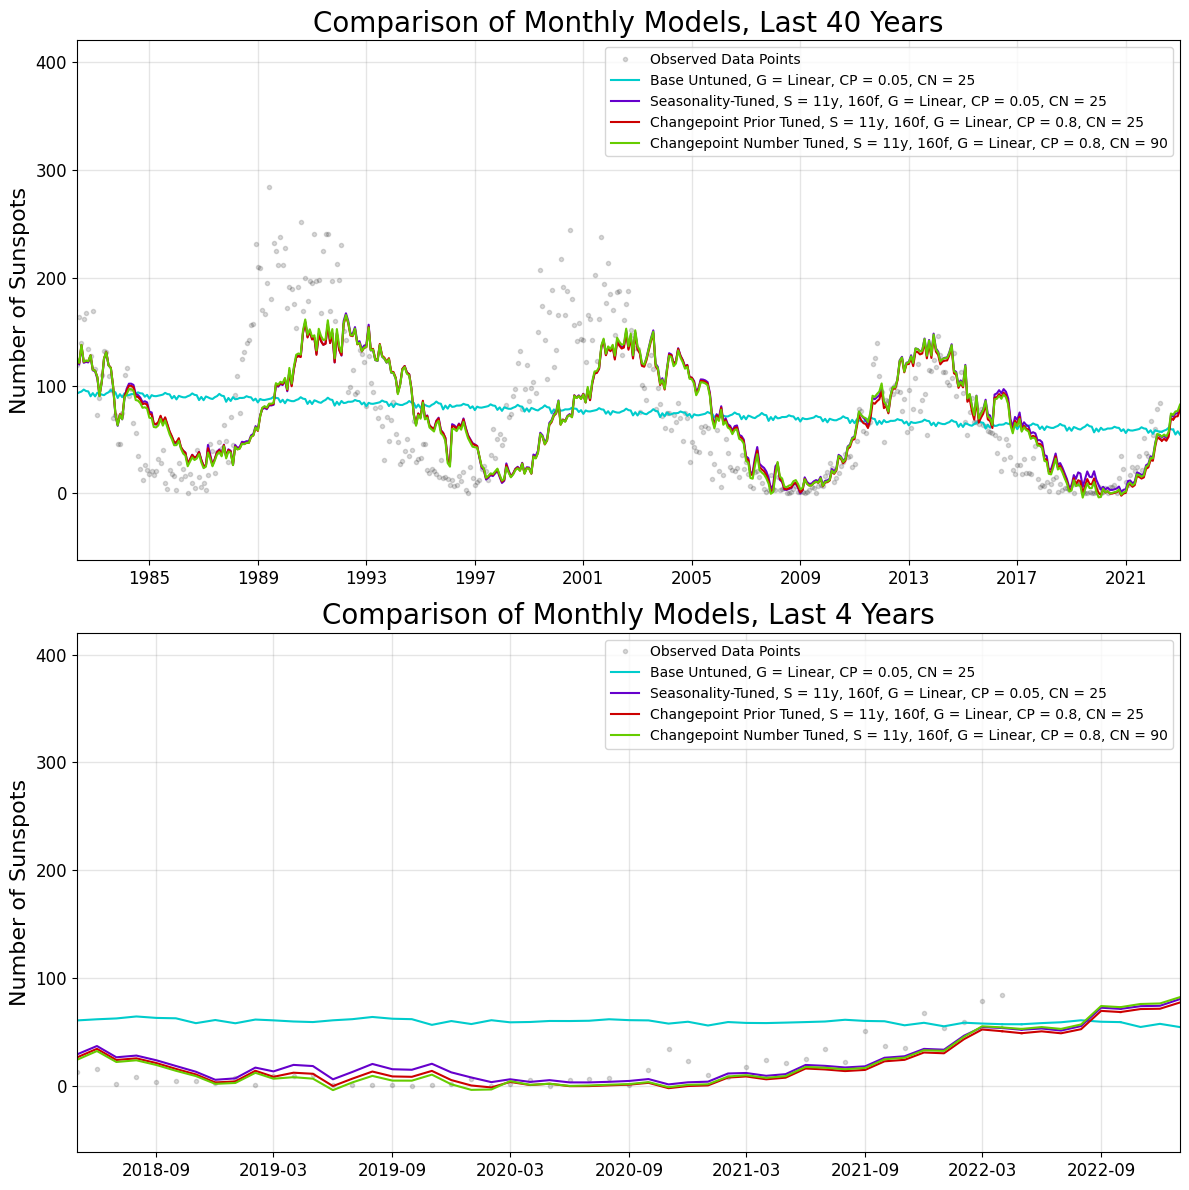

In [18]:
# Compare predictions of models at different steps of tuning
plot_params = {
    'models': models, 'model_names': model_titles, 'forecasts': forecasts,
    'prior_periods': [40 * 12, 4 * 12], 'prediction_periods': future_periods,
    'titles': [
        'Comparison of Monthly Models, Last 40 Years',
        'Comparison of Monthly Models, Last 4 Years'
    ]}

ev.plot_model_comparisons(**plot_params);

The best monthly model lags behind the data and appears to be underpredicting future data points.

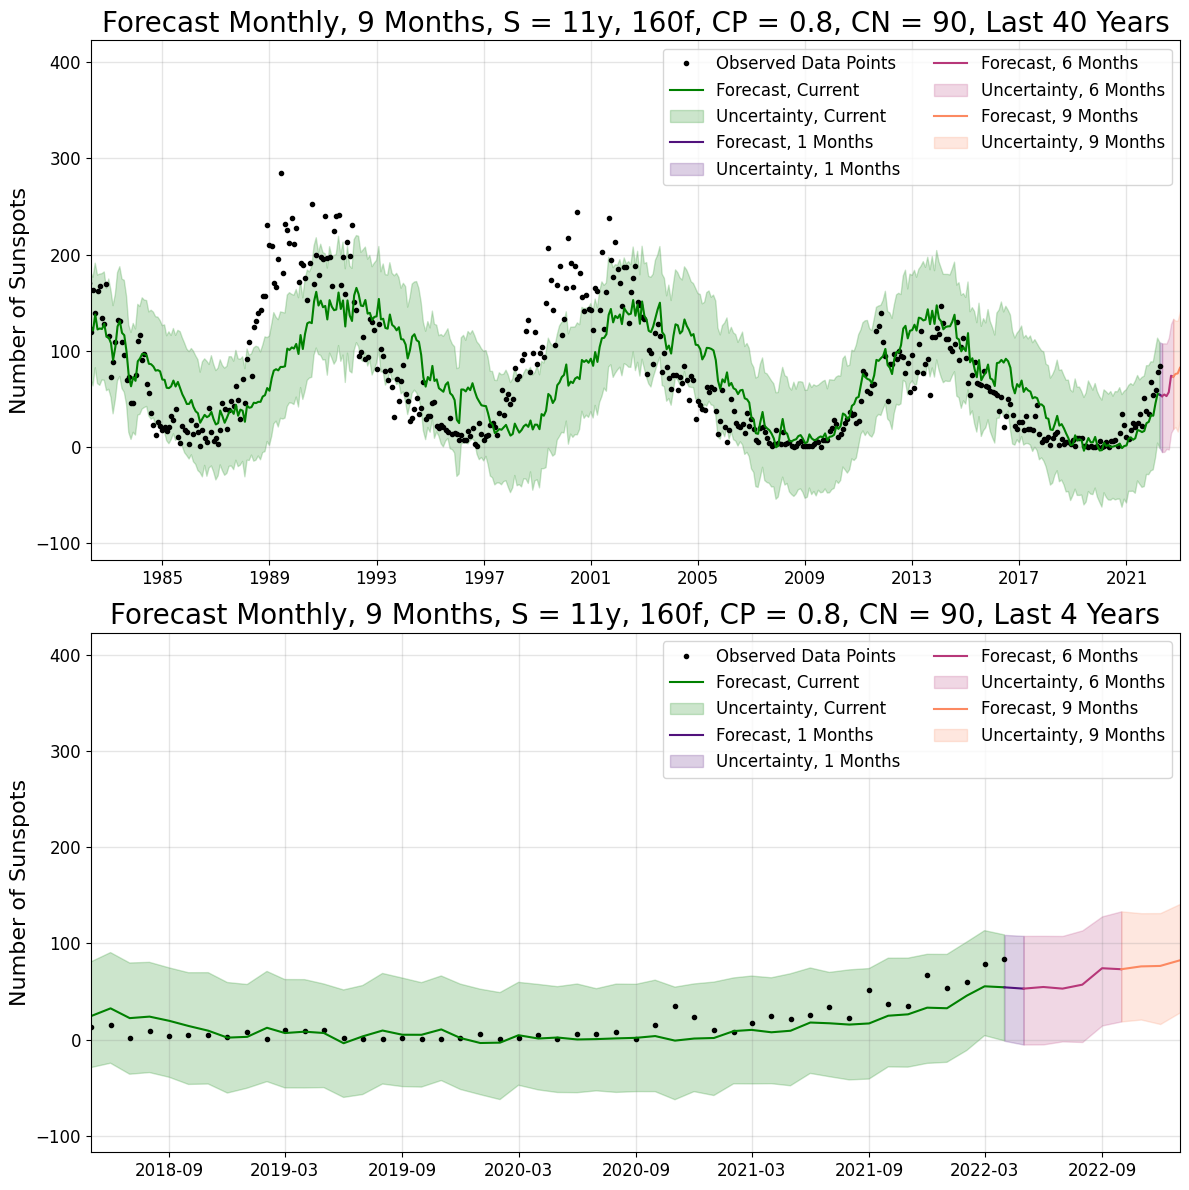

In [19]:
# Plotting best model predictions
idx = -1

plot_params = {
    'model': models[idx], 'current_fc': forecasts[idx][0], 'future_fc': forecasts[idx][1],
    'prior_periods': [40 * 12, 4 * 12], 'prediction_periods': future_periods,
    'uncertainties': True, 'periodicity': periodicity,
    'titles': [
        'Forecast Monthly, 9 Months, S = 11y, 160f, CP = 0.8, CN = 90, Last 40 Years',
        'Forecast Monthly, 9 Months, S = 11y, 160f, CP = 0.8, CN = 90, Last 4 Years'
    ]}

ev.plot_multi_timeframes(**plot_params);

Although the high fourier order of the seasonality was helpful for getting a better fit, the seasonality may perhaps be too noisy and not properly representative of the correct seasonality. The trend is also quite erratic due to the high changepoint prior value and number of changepoints, so although the model fits somewhat nicely, the interpretability of the components is low.

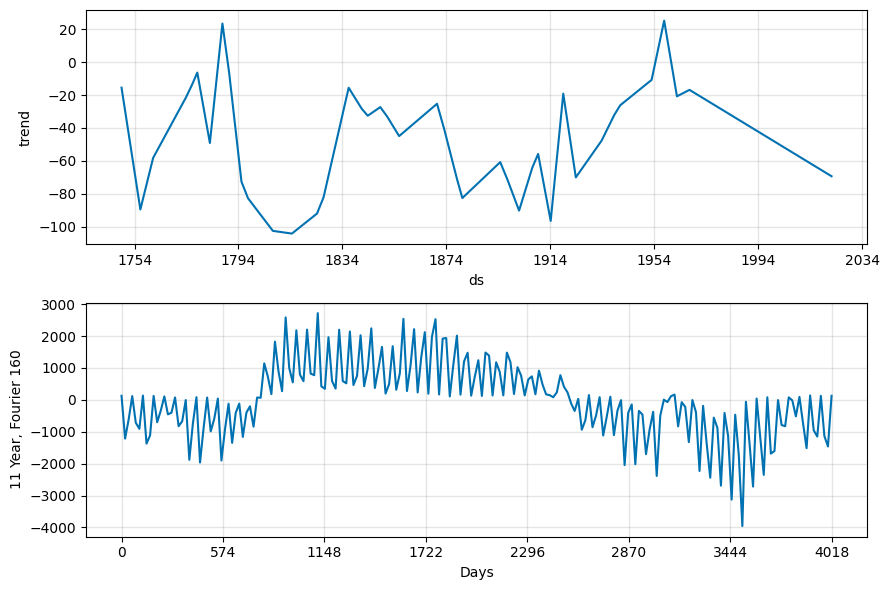

In [20]:
# Looking at best model components
models[idx].plot_components(forecasts[idx][0], uncertainty = False);